Working with dates in xarray is tricky. This notebook provides some basic understanding and examples of some common problems. Please feel free to contribute to it as you wish.

# Notes


## Date formats


- Typically when you read in a netcdf file from WACCM with xarray, the time dimension will have the following format:

    - array([cftime.DatetimeNoLeap(year, month, day, hour, minute, second, microsecond, has_year_zero=True)],  dtype=object)
    
    - Let's break this down:
       
        - array() 
            - (TODO - confirm) This represents an xarray DataArray data structure. Similar to numpy arrays, DataArrays can hold multiple values of the same data type or of different data types. Hence the first element is a list, and the second element is an argument specifying the data type of the array elements.
        - dtype=object
            - This means that the array can hold elements of any data type, as indicated by the "object" data type.
        - cftime.DatetimeNoLeap()
            - This is a specific type of date and time representation provided by the cftime module. It's used to represent dates and times with a specific calendar and handling of leap years. cftime.DatetimeNoLeap() is a class representing a date and time instance without leap years, which means it's suitable for calendars without leap years, such as the "No Leap" calendar.
        - has_year_zero=True 
            - This is an argument passed to the DatetimeNoLeap constructor. It specifies whether the calendar system includes a year zero or not. In this case, has_year_zero=True indicates that the calendar system includes a year zero.

- The format for instantaneous quantities is this ...

- The format for average quantities is this ... 

    - The date corresponds to the end of the time bound of the averaging period. E.g. if the data is an average for the month of January 2009, then the date shown will be 
        
        - 2009-02-01 00:00:00. 

    - Or in the object format

        - array([cftime.DatetimeNoLeap(2009, 2, 1, 0, 0, 0, 0, has_year_zero=True)],  dtype=object)

# Common problems and solutions with examples

## Converting from YYYYMM (or equivalent) date format to cftime.DatetimeNoLeap object

- If you have a dataset with a time coordinate with format YYYYMM (e.g. 200801 - January 2008) and you wish to convert to cftime.DatetimeNoLeap object, the below snippet shows you how.

- You may want to do this if for example you have many years of monthly data and wish to calculate the climatology over all years by grouping the data and averaging using ds.groupby("time.month").mean(dim="time") methods. 

- The "time.month" accessor will not work on dates with format YYYYMM

- The below example shows this for monthly mean T data for the years 2008-2012 from the MIPAS satellite, zonally averaged at 40N.

- To create a cftime.DatetimeNoLeap object, you can use

In [42]:
import cftime

Y = 2010
M = 1
D = 2
H = 3
m = 4
s = 5

datetime_no_leap = cftime.DatetimeNoLeap(Y, M, D, H, m, s, has_year_zero=True)

datetime_no_leap

cftime.DatetimeNoLeap(2010, 1, 2, 3, 4, 5, 0, has_year_zero=True)

To access all of the individual components you can use the accessors: year, month, day, hour, minute and second.


In [33]:

print(datetime_no_leap.year)
print(datetime_no_leap.month)
print(datetime_no_leap.day)
print(datetime_no_leap.hour)
print(datetime_no_leap.minute)
print(datetime_no_leap.second)

2010
1
2
3
4
5


Below shows this used on an example data set of monthly mean T data for years 2008 - 2012 from the MIPAS satellite zonally averaged at 40N.

In [48]:
%%time
import xarray as xr
import cftime
# Read in data for example
path = "./example_data/"
file = "MIPAS_T_40N_ZM_2008_2012.nc"
ds = xr.open_dataset(path + file)
# Inspect
ds

CPU times: user 6.75 ms, sys: 1.84 ms, total: 8.59 ms
Wall time: 6.85 ms


<xarray.Dataset>
Dimensions:  (time: 48, z: 29)
Coordinates:
  * time     (time) int64 200801 200802 200803 200804 ... 201110 201111 201112
    lat      float64 ...
  * z        (z) float32 50.0 52.0 54.0 56.0 58.0 ... 100.0 102.5 105.0 110.0
Data variables:
    T        (time, z) float64 ...

In [49]:
# Loop over time values and convert to cftime.DatetimeNoLeap object
cftime_values = []
for time_str in ds['time'].values:
    
    year = int(str(time_str)[0:4]) # Extract year 
    month = int(str(time_str)[4:])+1 # Extract month and add 1 due to xarray convention
    if month == 13:
        year = year + 1
        month = 1
    
    # Create a cftime.DatetimeNoLeap object
    datetime_no_leap = cftime.DatetimeNoLeap(year, month, 1, 0, 0, 0, has_year_zero=True)
    
    # Append the cftime.DatetimeNoLeap object to the list
    cftime_values.append(datetime_no_leap)
    
# Assign cftime_values list to time dimension in ds
ds['time'] = xr.DataArray(cftime_values, dims="time")
# Inspect dataset
ds

<xarray.Dataset>
Dimensions:  (time: 48, z: 29)
Coordinates:
  * time     (time) object 2008-02-01 00:00:00 ... 2012-01-01 00:00:00
    lat      float64 40.0
  * z        (z) float32 50.0 52.0 54.0 56.0 58.0 ... 100.0 102.5 105.0 110.0
Data variables:
    T        (time, z) float64 250.1 248.9 245.5 240.7 ... 223.1 228.2 244.5

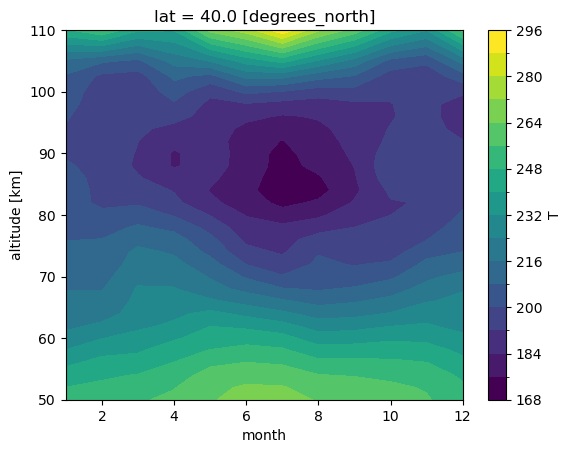

In [53]:
# Perform grouping and plot
ds_clim = ds.groupby("time.month").mean(dim="time")
ds_clim['T'].plot.contourf(y="z",levels=20)